### Import libraries

In [1]:
import os
import json
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error
from boruta import BorutaPy
from numpy import sqrt 

sns.set_style("whitegrid")
sns.set_palette("pastel")

### Read dataframe

In [2]:
df = pd.read_csv('data/df_emigrant_population.csv')
df.head(5)

,YEARS,COUNTIES,EMIGRANTS,BORN_URBAN,BORN_RURAL,DEAD_URBAN,DEAD_RURAL,DIVORCES_URBAN,DIVORCES_RURAL,UNEMPLOYMENT_RATE_MALE,UNEMPLOYMENT_RATE_FEMALE,EDUCATIONAL_UNITS,TEACHING_STAFF,CONFLICTS_OF_INTEREST,HOSPITALS
0,Anul 1992,Alba,625.00,2593.00,2211.00,23.00,20.00,388.00,132.00,4.00,7.30,782,5674.00,2.00,10.00
1,Anul 1993,Alba,545.00,2318.00,2125.00,16.00,18.00,343.00,125.00,6.60,9.70,803,5652.00,0.00,10.00
2,Anul 1994,Alba,272.00,2381.00,2028.00,18.00,12.00,570.00,183.00,6.80,9.40,775,5853.00,1.00,9.00
3,Anul 1995,Alba,466.00,2138.00,1936.00,17.00,11.00,448.00,150.00,4.80,9.20,774,5831.00,0.00,9.00
4,Anul 1996,Alba,330.00,2183.00,1876.00,19.00,18.00,458.00,161.00,3.20,6.00,780,6065.00,0.00,10.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   YEARS                     1260 non-null   object 
 1   COUNTIES                  1260 non-null   object 
 2   EMIGRANTS                 1260 non-null   float64
 3   BORN_URBAN                1260 non-null   float64
 4   BORN_RURAL                1260 non-null   float64
 5   DEAD_URBAN                1260 non-null   float64
 6   DEAD_RURAL                1260 non-null   float64
 7   DIVORCES_URBAN            1260 non-null   float64
 8   DIVORCES_RURAL            1260 non-null   float64
 9   UNEMPLOYMENT_RATE_MALE    1260 non-null   float64
 10  UNEMPLOYMENT_RATE_FEMALE  1260 non-null   float64
 11  EDUCATIONAL_UNITS         1260 non-null   int64  
 12  TEACHING_STAFF            1260 non-null   float64
 13  CONFLICTS_OF_INTEREST     1260 non-null   float64
 14  HOSPITAL

In [4]:
df.describe()

,EMIGRANTS,BORN_URBAN,BORN_RURAL,DEAD_URBAN,DEAD_RURAL,DIVORCES_URBAN,DIVORCES_RURAL,UNEMPLOYMENT_RATE_MALE,UNEMPLOYMENT_RATE_FEMALE,EDUCATIONAL_UNITS,TEACHING_STAFF,CONFLICTS_OF_INTEREST,HOSPITALS
count,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00,1260.00
mean,394.32,2623.26,2556.40,11.91,13.88,526.34,227.47,7.26,7.03,371.79,6349.85,2.81,11.07
std,601.20,2598.42,1303.61,10.97,10.02,442.09,122.26,3.84,3.90,278.00,4075.56,4.79,10.24
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,71.00,0.00,0.00,0.00
25%,107.00,1425.00,1745.75,5.00,7.00,264.00,145.00,4.40,4.20,148.00,3908.00,0.00,6.00
50%,241.50,2012.50,2300.50,9.00,12.00,429.00,200.00,6.90,6.30,241.50,5404.00,1.00,8.00
75%,445.50,3188.00,3212.75,15.00,18.00,649.00,292.00,9.70,9.00,570.50,7969.25,4.00,13.00
max,6326.00,24007.00,7597.00,94.00,80.00,3949.00,702.00,25.20,25.10,1176.00,32289.00,38.00,93.00


### Benchmark model

I've decided to start with the simplest model without any preprocessing or feature engineering. This will serve as our benchmark.

In [5]:
# Select the predictors and the target variable
X = df.drop(['YEARS', 'COUNTIES', 'EMIGRANTS'], axis=1)
y = df['EMIGRANTS']

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:19<00:00,  2.12it/s]


Let's now examine the model's performance metrics.

In [6]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.71,0.72,391.53,0.40
KNeighborsRegressor,0.70,0.71,398.01,0.02
RandomForestRegressor,0.68,0.69,410.81,1.04
LGBMRegressor,0.67,0.68,415.86,0.07
BaggingRegressor,0.67,0.68,416.70,0.12
OrthogonalMatchingPursuit,0.66,0.67,420.43,0.01
HistGradientBoostingRegressor,0.66,0.67,421.54,0.50
OrthogonalMatchingPursuitCV,0.65,0.67,425.36,0.01
GradientBoostingRegressor,0.65,0.66,428.31,0.38


Considering we used the model without any data preprocessing or feature engineering, the results are not too bad.

Random Forest Regressor and LGBM Regressor are both Ensembles algorithms and they will not be affected by multicolinearity. Also, we don't need to normalize our data since the decisions will be made in a "tree" format.

### Check correlation matrix

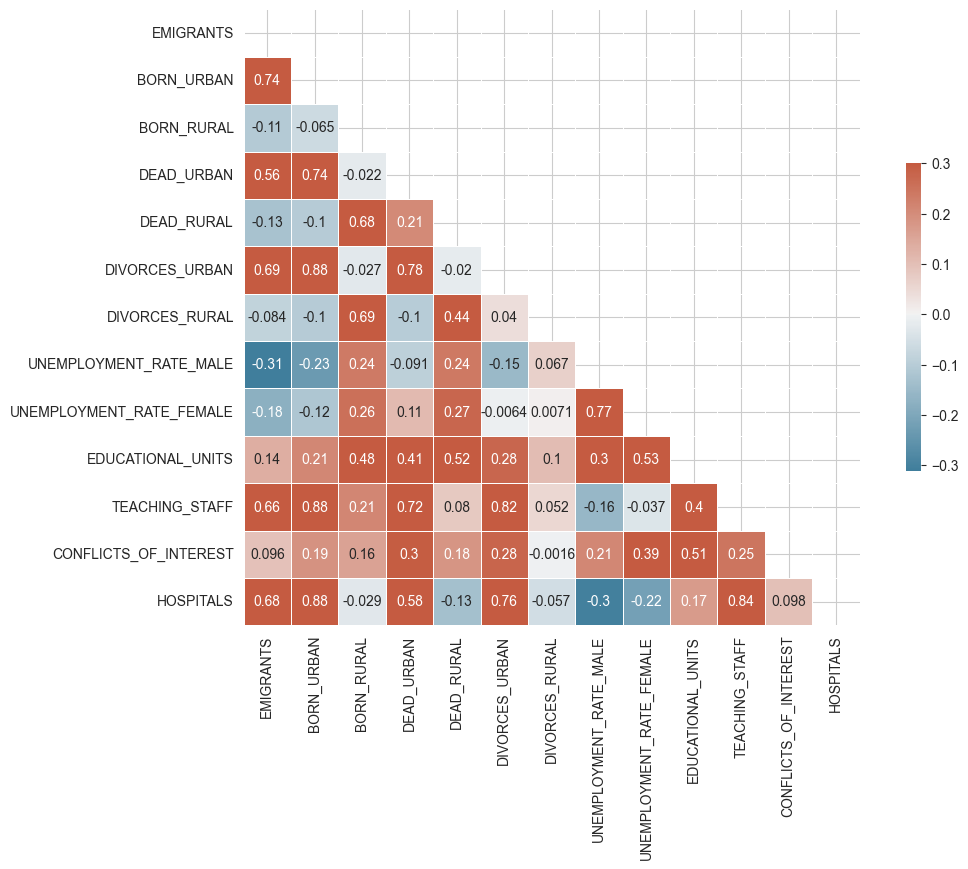

In [7]:
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

Based on these correlations, here is an interpretation of the results with consideration to Romania's socio-economic context:
- EMIGRANTS and BORN_URBAN (0.74): This strong positive correlation might suggest that urban areas, which tend to have better healthcare and higher birth rates, might also be the areas from which people emigrate. This could be due to reasons such as seeking better economic opportunities, higher education, or better quality of life in other countries.
- EMIGRANTS and BORN_RURAL (-0.11): The weak negative correlation here might suggest that rural areas, despite having lower healthcare facilities and birth rates, do not significantly contribute to emigration. This could be attributed to the fact that people from rural areas might face additional barriers to emigration such as lack of education, information, and financial resources.
- BORN_URBAN and DIVORCES_URBAN (0.88): This high correlation might indicate that areas with higher population (more urban births) also tend to have more instances of divorces. This might be due to factors such as changing social norms, increased financial independence, or higher stress levels in urban areas.
- UNEMPLOYMENT_RATE_MALE and UNEMPLOYMENT_RATE_FEMALE (0.77): The positive correlation suggests that unemployment trends are similar for both genders. It may also highlight that economic conditions, impacting employment rates, affect both genders concurrently.
- EDUCATIONAL_UNITS and UNEMPLOYMENT_RATE_FEMALE (0.53): The moderate positive correlation here might seem counter-intuitive at first, as one might expect more education to correlate with lower unemployment. However, this might reflect the social realities of Romania where women, despite having access to education, might still face barriers in the labour market.
- HOSPITALS and TEACHING_STAFF (0.84): This strong correlation might indicate that regions with more hospitals, which are usually urban or developed areas, tend to have better educational facilities and hence more teaching staff.
- DEAD_RURAL and BORN_RURAL (0.68): The moderate positive correlation here might suggest that rural areas, despite having lower birth rates compared to urban areas, might have higher death rates. This might be due to lack of healthcare facilities, difficult living conditions, and other socio-economic factors in rural Romania.

### Feature engineering

In [8]:
# Add a small constant to avoid division by zero
small_constant = 0.0001

# Creating interaction features
df['Urban_Rural_Birth_Ratio'] = df['BORN_URBAN'] / (df['BORN_RURAL'] + small_constant)
df['Urban_Rural_Death_Ratio'] = df['DEAD_URBAN'] / (df['DEAD_RURAL'] + small_constant)
df['Urban_Rural_Divorce_Ratio'] = df['DIVORCES_URBAN'] / (df['DIVORCES_RURAL'] + small_constant)
df['Male_Female_Unemployment_Ratio'] = df['UNEMPLOYMENT_RATE_MALE'] / (df['UNEMPLOYMENT_RATE_FEMALE'] + small_constant)
df['Hospital_Educational_Unit_Ratio'] = df['HOSPITALS'] / (df['EDUCATIONAL_UNITS'] + small_constant)
df['Teaching_Staff_Educational_Unit_Ratio'] = df['TEACHING_STAFF'] / (df['EDUCATIONAL_UNITS'] + small_constant)
df['Urban_Birth_Death_Ratio'] = df['BORN_URBAN'] / (df['DEAD_URBAN'] + small_constant)
df['Rural_Birth_Death_Ratio'] = df['BORN_RURAL'] / (df['DEAD_RURAL'] + small_constant)
df['Conflict_Educational_Unit_Ratio'] = df['CONFLICTS_OF_INTEREST'] / (df['EDUCATIONAL_UNITS'] + small_constant)

- Urban-Rural Birth Ratio: This feature can be created by dividing the BORN_URBAN column by the BORN_RURAL column. This ratio will capture the proportion of urban births to rural births in a particular year. It can provide information about where the population growth is happening and could impact the emigration rates.
- Urban-Rural Death Ratio: Similar to the above, dividing the DEAD_URBAN column by the DEAD_RURAL column will create a ratio that captures where more deaths are happening.
- Urban-Rural Divorce Ratio: The DIVORCES_URBAN divided by DIVORCES_RURAL can indicate where more separations are happening, which might affect emigration patterns.
- Male-Female Unemployment Ratio: This could be created by dividing UNEMPLOYMENT_RATE_MALE by UNEMPLOYMENT_RATE_FEMALE. The resulting ratio will reflect gender disparities in unemployment, which could potentially affect emigration rates.
- Hospital to Educational Unit Ratio: The HOSPITALS column divided by EDUCATIONAL_UNITS can provide a sense of the balance between healthcare and educational institutions in a region. The availability and quality of such institutions could have an impact on emigration.
- Teaching Staff to Educational Unit Ratio: The TEACHING_STAFF divided by EDUCATIONAL_UNITS can indicate the average size of the teaching staff per educational unit. Regions with a higher ratio may offer a better education, possibly affecting emigration.
- Birth-Death Ratio (Urban and Rural separately): The BORN_URBAN divided by DEAD_URBAN and BORN_RURAL divided by DEAD_RURAL can provide information on the growth or decline of the population in both urban and rural settings.
- Conflict to Educational Unit Ratio: The CONFLICTS_OF_INTEREST column divided by EDUCATIONAL_UNITS could provide insight into the amount of conflict relative to the number of educational units in a region, which might have an influence on emigration.

### Model building

Next, we separated our data into a training set and a testing set. The training set, as the name suggests, is used to train our model. The testing set is set aside and used to evaluate how well our model performs on data it hasn't seen before.

In [21]:
test = df[df['YEARS'].isin([' Anul 2020', ' Anul 2021'])]
train = df.drop(test.index)

test.set_index(['YEARS', 'COUNTIES'], inplace=True)
train.set_index(['YEARS', 'COUNTIES'], inplace=True)

y_train = train[['EMIGRANTS']]
X_train = train.drop(['EMIGRANTS'], axis=1)

y_test = test[['EMIGRANTS']]
X_test = test.drop(['EMIGRANTS'], axis=1)

##### Hypertuning function using Optuna

In [10]:
def objective(trial):
    # create the LightGBM model
    gbm = lgb.LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        learning_rate=trial.suggest_float('learning_rate', 1e-6, 1e-0),
        num_leaves=trial.suggest_int('num_leaves', 2, 150),
        max_depth=trial.suggest_int('max_depth', 1, 100),
        subsample=trial.suggest_float('subsample', 0.01, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0),
        reg_alpha=trial.suggest_float('reg_alpha', 0.01, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-4, 1),
        min_split_gain=trial.suggest_float('min_split_gain', 1e-9, 1e2),
        random_state=42,
        metric='l2',    # Mean Squared Error (MSE)
        verbose=-1
    )

    # fit the model
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    return sqrt(mean_squared_error(y_test, y_pred))

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=2000, show_progress_bar=False)

# Count existing files
existing_files = os.listdir('parameters')
relevant_files = [f for f in existing_files if f.startswith('best_params_')]
numbers = [int(f.split('_')[2].split('.')[0]) for f in relevant_files]
next_number = max(numbers) + 1 if numbers else 1

# Save the results
with open(f'parameters/best_params_{next_number}.json', 'w') as f:
    json.dump(study.best_params, f)

print(study.best_params)

{'n_estimators': 116, 'learning_rate': 0.6053453150923039, 'num_leaves': 51, 'max_depth': 29, 'subsample': 0.7966148653102302, 'colsample_bytree': 0.7238812507478442, 'reg_alpha': 0.9261413076221101, 'reg_lambda': 0.6940310295928778, 'min_split_gain': 99.86300278097593}


To optimize the performance of our model, we used a library called Optuna. Optuna helps us find the best hyperparameters for our LightGBM model. Hyperparameters are parameters that aren't learned from the data but are set beforehand and control the learning process. Finding the optimal set of hyperparameters can significantly improve the performance of our model.

##### Fit the model on our data

In [22]:
with open('parameters/best_params_1.json', 'r') as f:
    params = json.load(f)
    
gbm = lgb.LGBMRegressor(**params, random_state=42, metric='L2')
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

##### Feature importance

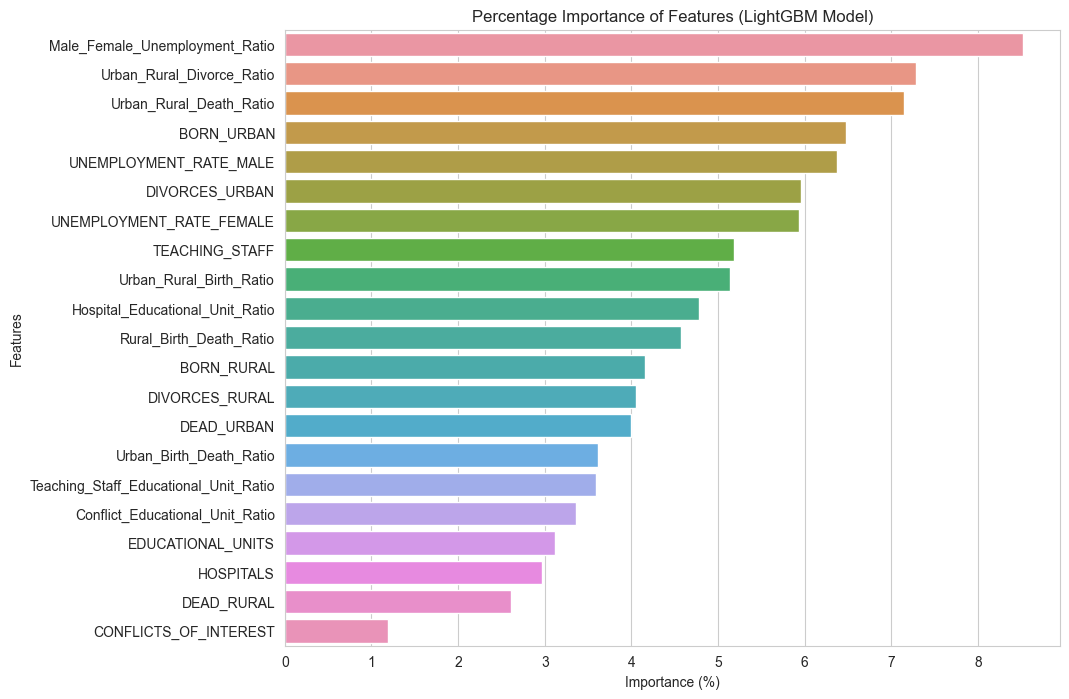

In [24]:
# Extract feature importance from the trained model
feature_importance = gbm.feature_importances_

# Calculate percentage importance
total_importance = sum(feature_importance)
percentage_importance = (feature_importance / total_importance) * 100

# Create DataFrame for percentage importance
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': percentage_importance})

# Sort DataFrame by importance
feature_imp_df = feature_imp_df.sort_values('Importance', ascending=False)

# Create a barplot
plt.figure(figsize=(10, 8))
sns.barplot(y='Feature', x='Importance', data=feature_imp_df)
plt.title('Percentage Importance of Features (LightGBM Model)')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.show()

##### Check the metrics

Once we have our trained and tuned model, we evaluate its performance by comparing the predicted emigration rates to the actual emigration rates from our test set. We use two metrics to do this: the Root Mean Squared Error (RMSE) and R-Squared. The RMSE gives us an idea of how close, on average, our predictions are to the actual values. R-Squared, also known as the coefficient of determination, tells us how well our model fits the data. A higher R-Squared indicates a better fit.

In [12]:
mse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: {:.2f}".format(mse))
print("R-squared: {:.3f}".format(r2))

RMSE: 370.27
R-squared: 0.752


##### Perform a visual check over the prediction

To further investigate our model's performance, we visualized our predictions against the actual emigration rates. This visual check can help us understand if there are any systematic errors in our predictions, such as underestimating or overestimating certain ranges of emigration rates.

In [13]:
data = {'y_pred': y_pred, 'y_test': np.array(y_test['EMIGRANTS'])}
df_check = pd.DataFrame(data)
df_check = pd.DataFrame(data, columns=['y_pred', 'y_test'])

##### Feature selection

To potentially improve our model's performance, we performed feature selection using Boruta, a feature ranking and selection algorithm. This can help us eliminate irrelevant or redundant features from our model, reducing the risk of overfitting and improving interpretability.

In [14]:
# Apply Boruta to see if we can acquire better results
gbm = lgb.LGBMRegressor(**params, random_state=42, metric='L2')
feat_selector = BorutaPy(gbm, n_estimators=1000, verbose=1, max_iter=30, alpha=0.1, random_state=42)
feat_selector.fit(X_train.values, y_train.values.ravel())
cols = X_train.columns
selected_cols = cols[feat_selector.support_]
print(selected_cols)

Iteration: 1 / 30
Iteration: 2 / 30
Iteration: 3 / 30
Iteration: 4 / 30
Iteration: 5 / 30
Iteration: 6 / 30
Iteration: 7 / 30
Iteration: 8 / 30
Iteration: 9 / 30
Iteration: 10 / 30
Iteration: 11 / 30
Iteration: 12 / 30
Iteration: 13 / 30
Iteration: 14 / 30
Iteration: 15 / 30
Iteration: 16 / 30
Iteration: 17 / 30
Iteration: 18 / 30
Iteration: 19 / 30
Iteration: 20 / 30
Iteration: 21 / 30
Iteration: 22 / 30
Iteration: 23 / 30
Iteration: 24 / 30
Iteration: 25 / 30
Iteration: 26 / 30
Iteration: 27 / 30
Iteration: 28 / 30
Iteration: 29 / 30


BorutaPy finished running.

Iteration: 	30 / 30
Confirmed: 	4
Tentative: 	2
Rejected: 	15
Index(['BORN_URBAN', 'Urban_Rural_Death_Ratio',
       'Male_Female_Unemployment_Ratio', 'Hospital_Educational_Unit_Ratio'],
      dtype='object')


##### Retraining model with selected features

Finally, after selecting the most relevant features, we retrained our model using the updated dataset and repeated the hyperparameter tuning process. We then evaluated our refined model using the same metrics (RMSE and R-Squared).

In [15]:
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

In [16]:
study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=1500, show_progress_bar=False)

In [17]:
# Count existing files
existing_files = os.listdir('parameters')
relevant_files = [f for f in existing_files if f.startswith('best_params_')]
numbers = [int(f.split('_')[2].split('.')[0]) for f in relevant_files]
next_number = max(numbers) + 1 if numbers else 1

# Save the results
with open(f'parameters/best_params_{next_number}.json', 'w') as f:
    json.dump(study.best_params, f)

print(study.best_params)

{'n_estimators': 110, 'learning_rate': 0.03606308098121286, 'num_leaves': 143, 'max_depth': 40, 'subsample': 0.5492749197444566, 'colsample_bytree': 0.9704852947448913, 'reg_alpha': 0.983680781306417, 'reg_lambda': 0.2362031935636648, 'min_split_gain': 11.534479056296448}


In [18]:
with open('parameters/best_params_2.json', 'r') as f:
    params = json.load(f)
    
gbm = lgb.LGBMRegressor(**params, random_state=42, metric='L2')
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

In [19]:
mse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: {:.2f}".format(mse))
print("R-squared: {:.3f}".format(r2))

RMSE: 491.72
R-squared: 0.563
